# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Read the data first

In [142]:
from nb_utils import read_commits

# model files per repository and the elapsed days between the commit and safetensor's release date
df = read_commits()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']
df_safetensors

,repo_url,commit_hash,model_file_path,serialization_format,date,message,elapsed_days
0,microsoft/resnet-50,34c2154c194f829b11125337b98c8f5f9965ff19,microsoft/resnet-50/model.safetensors,safetensors,2024-02-13 16:24:05,Adding `safetensors` variant of this model (#4...,508
3,microsoft/resnet-18,f45a6faa12e0381f5620c5c8d7e916bca90f2c44,microsoft/resnet-18/model.safetensors,safetensors,2023-05-08 07:19:40,Adding `safetensors` variant of this model (#2...,227
6,pritamdeka/BioBert-PubMed200kRCT,73ac04efdc8a89e33c98950dedb72a523a7627eb,pritamdeka/BioBert-PubMed200kRCT/model.safeten...,safetensors,2023-03-24 05:56:58,Adding `safetensors` variant of this model (#1...,182
24,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-12L-95M-i4096/model.s...,safetensors,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
26,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-12L-95M-i4096_CLcance...,safetensors,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
...,...,...,...,...,...,...,...
7119,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,EleutherAI/gpt-neox-20b/model-00044-of-00046.s...,safetensors,2023-02-07 01:46:15,Adding `safetensors` variant of this model (#1...,137
7120,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,EleutherAI/gpt-neox-20b/model-00045-of-00046.s...,safetensors,2023-02-07 01:46:15,Adding `safetensors` variant of this model (#1...,137
7121,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,EleutherAI/gpt-neox-20b/model-00046-of-00046.s...,safetensors,2023-02-07 01:46:15,Adding `safetensors` variant of this model (#1...,137
7171,bigscience/T0pp,7df7b1c1aa361dd74049d0b794a01801fb4563de,bigscience/T0pp/model.safetensors,safetensors,2024-03-19 12:02:07,Adding `safetensors` variant of this model (#1...,543


## Analysis 1: How many commits containing safetensors files were made by the SFconvertbot?

HuggingFace has a bot (https://huggingface.co/SFconvertbot) that converts models to safetensors.
How many commits were made by the bot and how many were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [143]:
from pathlib import Path

bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_bot = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_bot = df_safetensors[df_safetensors['message'].str.contains(bot_message)]

num_commits = len(df['commit_hash'].unique())
num_safetensors_commits = len(df_safetensors['commit_hash'].unique())
num_safetensors_commits_by_bot = len(df_safetensors_by_bot['commit_hash'].unique())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_bot['commit_hash'].unique())

print(f"# commits: {num_commits}")
print(f"# commits touching safetensor files: {num_safetensors_commits}")
print(f"% commits made by the bot: {num_safetensors_commits_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_by_bot})")
print(f"% commits made by developers: {num_safetensors_commits_not_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_not_by_bot})")


df_safetensors_not_by_bot.to_csv(Path('../../results/safetensors_commits_not_by_bot.csv'), index=False)
df_safetensors_by_bot.to_csv(Path('../../results/safetensors_commits_by_bot.csv'), index=False)

# commits: 4095
# commits touching safetensor files: 436
% commits made by the bot: 85.1% (371)
% commits made by developers: 14.9% (65)


## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

In [144]:
# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()
min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos without safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("min, quartile2, median, quartile4, max=",min, quartile2, median, quartile4, max)

Number of analyzed repos:  844
Number of repos without safetensors: 460
Number of repos using safe tensors 384
min, quartile2, median, quartile4, max= 6 227.75 520.5 551.0 733


## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

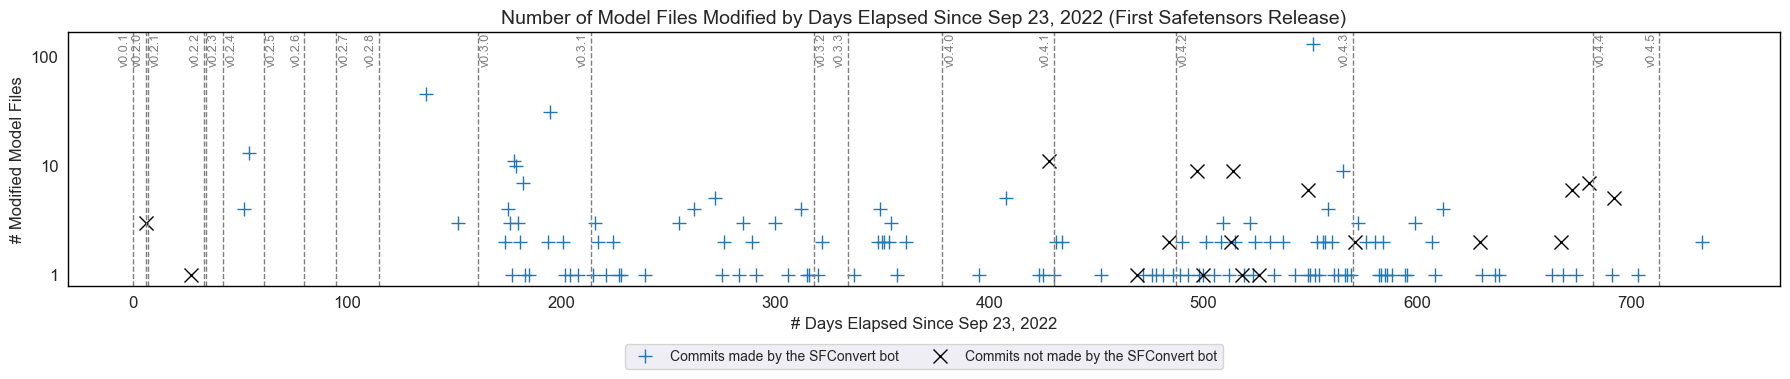

In [174]:
from pathlib import Path
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_bot['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_bot['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(18,4), facecolor="white")  # Set figure background to white
ax = plt.gca()  # Get the current axis
ax.set_facecolor("white")  # Set axis background to white

# Ensure the visibility of x-axis and y-axis lines (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)


plt.plot(commits_by_bot.index, commits_by_bot.values, marker='+', linestyle='None', markersize=10,  label="Commits made by SFConvert bot")
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values, marker='x', linestyle='None', color='black', markersize=10, label="Commits not made by SFConvert bot")

plt.xlabel("# Days Elapsed Since Sep 23, 2022", fontsize=12)
plt.ylabel("# Modified Model Files", fontsize=12)
plt.title("Number of Model Files Modified by Days Elapsed Since Sep 23, 2022 (First Safetensors Release)", fontsize=14)
plt.yscale('log')
plt.yticks([1, 10, 100], ['1', '10', '100'], fontsize=12)
plt.xticks(fontsize=12)
plt.grid(True)



df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
color, i, x_coordinates = 'tab:gray', 0, [1, -6.5]

for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff,color=color, linestyle='--', linewidth=1)
    x_offset = 1.5 if label == 'v0.2.4' else  x_coordinates[i]
    plt.text(diff + x_offset, plt.ylim()[1] * 0.99, label, color=color, rotation=90, verticalalignment='top', fontdict={'size':9.0})
    if label == 'v0.0.1': i = 2
    

plt.legend(('Commits made by the SFConvert bot','Commits not made by the SFConvert bot'),loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.tight_layout()
# Save the plot as a PDF file
plt.savefig(Path('../../results/RQ1CommitsDistribution.pdf'), format="pdf", bbox_inches="tight")

plt.show()

## Analysis 4: Number of adoptions as heatmap

C:\Users\Matt\AppData\Local\Temp\ipykernel_2536\152565224.py:97: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red", edgecolor="red"))
C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.canvas.draw()
C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  fig.canvas.draw()
C:\Users\Matt\AppData\Local\Temp\ipykernel_2536\152565224.py:114: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  plt.savefig(Path('../../results/RQ1Heatmap.pdf'), bbox_inches='tight', format='pdf')
C:\Users\Matt\AppData\Local\Temp\ipykernel_2536\152565224.py:114: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  plt.savefig(Path('../../results/RQ1Heatmap.

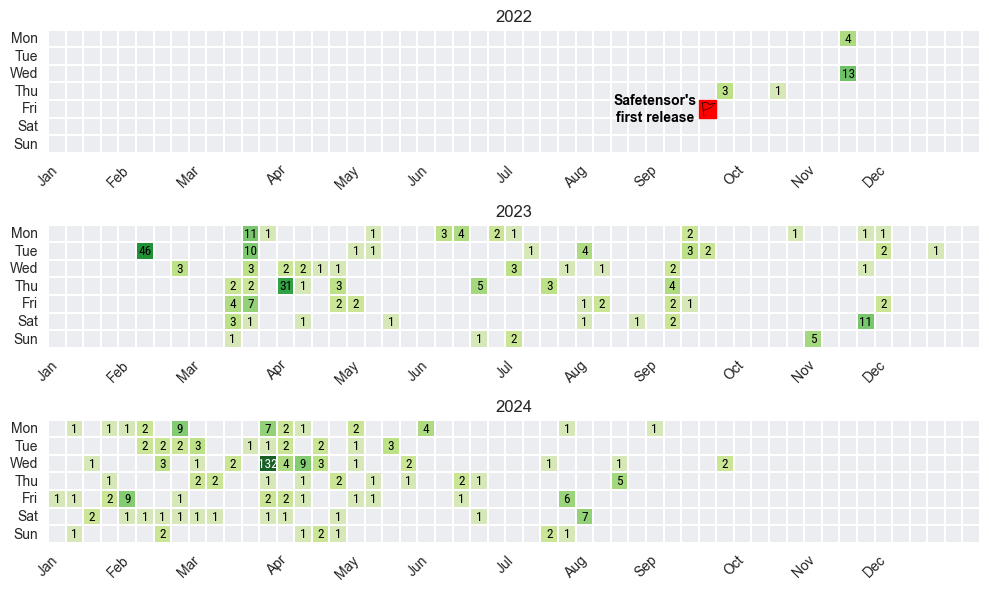

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import pandas as pd

from matplotlib.patches import Rectangle
from matplotlib.font_manager import FontProperties

# Create a font property with Noto Emoji
emoji_font = FontProperties(fname=Path('../../assets/NotoEmoji-Regular.ttf'))
roboto_condensed_font = FontProperties(fname=Path('../../assets/RobotoCondensed-Regular.ttf'))
                            
                            

# group by timestamp, and ignore the times, just group based on the date
commits_by_date = df_safetensors.groupby(df_safetensors['date'].dt.floor('D')).size().sort_index()

# add all dates from SAFE TENSORS RELEASE DATE to today
for i in range(0, (pd.Timestamp.today() - SAFETENSORS_RELEASE_DATE).days):
    date = SAFETENSORS_RELEASE_DATE + pd.Timedelta(days=i)
    if date not in commits_by_date.index:
        commits_by_date.loc[date] = 0
commits_by_date = commits_by_date.sort_index()
# name the count as 'count'
commits_by_date.name = 'count'

# Ensure 'files_modified_by_date' has datetime as the index if not already
commits_by_date.index = pd.to_datetime(commits_by_date.index)

# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()
vmin = commits_by_date.min()
# Apply a logarithmic transformation to the data to manage outliers
import numpy as np

# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_annotations(year, ax):
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts for annotation
    year_data = year_data.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix = np.zeros((7, 53))
    year_matrix_original = np.zeros((7, 53))

    for i, (date, value) in enumerate(year_data.items()):
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, color='black' if year_matrix_original[row, col] < vmax else 'white', fontproperties=roboto_condensed_font)

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    
    if year == 2022:
        # Define the day and week position to highlight
        highlight_day = 4  # Example: 2 for Wednesday
        highlight_week = 37  # Example week to highlight
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red", edgecolor="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week - 2.5, highlight_day + 0.5, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold', fontdict={'family': 'sans-serif'})
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, '🚩', fontproperties=emoji_font,
                        ha='center', va='center', fontsize=10, color='black' )

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(10, 6))

for i, year in enumerate(years):
    plot_year_heatmap_with_annotations(year, axes[i])

plt.tight_layout()


# save as PDF on results folder and crop white spaces on the sides
plt.savefig(Path('../../results/RQ1Heatmap.pdf'), bbox_inches='tight', format='pdf')



plt.show()

In [147]:
commits_by_date

date
2022-09-23    0
2022-09-24    0
2022-09-25    0
2022-09-26    0
2022-09-27    0
             ..
2024-10-27    0
2024-10-28    0
2024-10-29    0
2024-10-30    0
2024-10-31    0
Name: count, Length: 770, dtype: int64